# Binary classification using a pre-trained convolutional neural network
This cNN makes use of the pretrained VGG16 model. Training was done using the Caltech 101 image set (slightly augmented) and the Figaro1k hair image set.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
import matplotlib.pyplot as plt

In [3]:
img_width, img_height = 200, 200
  
# Find the images
# Set model hyperparameters
train_data_dir = './binary_hair_nonhair/train/'
validation_data_dir = './binary_hair_nonhair/test/'
nb_train_samples = 840+860
nb_validation_samples = 210+217
epochs = 60
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
# Extract base of VGG16 model:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

In [ ]:
# Add 2 trainable layers on top:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

In [6]:
train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary') 
  
validation_generator = test_datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary') 

Found 1700 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [7]:
# Inspect batch
sample_training_images, _ = next(train_generator)

In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

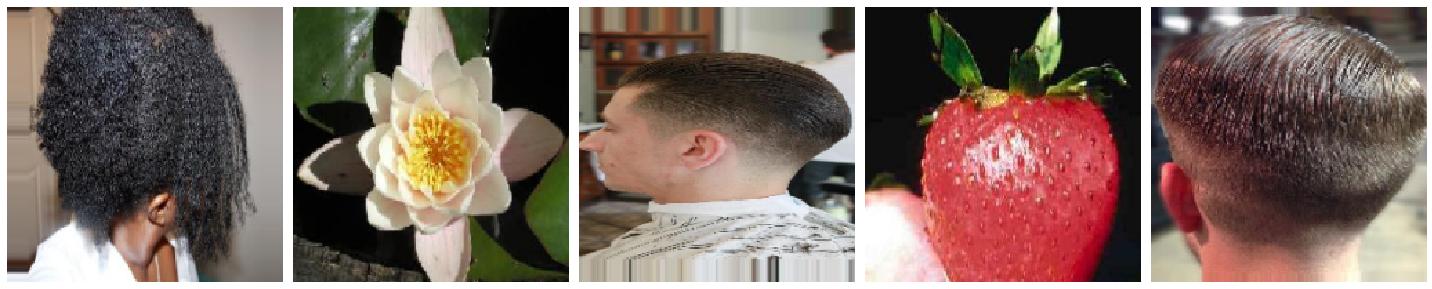

In [9]:
plotImages(sample_training_images[:5])

In [10]:
# Define some metrics to judge the model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1_m,precision_m, recall_m])

fit_history = model.fit_generator( 
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size) 

In [ ]:
# Save the model weights for later prediction
model.save_weights('model_binary_saved_VGG16.h5') 

In [ ]:
# Save the model
import pickle
pickle.dump(fit_history.history, open('model_history_binary_VGG.pkl','wb'))

In [ ]:
classes = train_generator.class_indices
print(classes)

In [ ]:
# Visualize the metrics
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']

loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('VGG.binary.png')
plt.show()